# Section 3.4 Overlaying co-expression networks with pathway knowledge supports the identification of disease associated pathways

In [1]:
import getpass
import json
import os
import sys
import time
from itertools import product
from typing import List

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ora
import pandas as pd
import pyobo
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from network_utils import create_network_from_edge_file, edge_file_path, load_interactome, pathway_similarity, \
    pathway_similarity_via_interactome
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
getpass.getuser()

'rfigueiredo'

In [3]:
sys.version

'3.9.1 (v3.9.1:1e5d33e9b9, Dec  7 2020, 12:10:52) \n[Clang 6.0 (clang-600.0.57)]'

In [4]:
time.asctime()

'Fri Feb 26 23:05:25 2021'

##### Increase figure quality

In [5]:
mpl.rcParams['figure.dpi'] = 320

## Load data
#### download data from https://doi.org/10.5281/zenodo.4572853 and place the folder 'data/' in the root of the repository, or if placed elsewhere, write the full path to 'data/' as the variable data_dir below

#### optional: select your desired location of the output figures

In [6]:
# replace here the location of the data dir if not structured as instructed
data_dir = "../data"

# optional, replace here the desired location of the output figures
figures_dir = os.path.join(os.path.expanduser("~"), "coexpath_figures")
os.makedirs(figures_dir, exist_ok=True)

##### Load co-expression networks

In [7]:
network_dict = {
    doid : create_network_from_edge_file(edge_file_path(os.path.join(data_dir, "final_coexprNets"), doid), doid)
    for doid in tqdm(os.listdir(os.path.join(data_dir,"final_coexprNets")), desc="Creating/loading network objects") if doid != "normal"
}

Creating/loading network objects: 100%|██████████| 64/64 [03:31<00:00,  3.30s/it]


##### Load interactome network

In [8]:
interactome = load_interactome(os.path.join(data_dir,"interactome_18_01_2021.tsv"))

##### Load cluster assignments

In [9]:
with open(os.path.join(data_dir, "misc_data", 'doid_group_clusters_dict.json'), 'r') as f:
    doids_per_cluster = json.load(f)

doid_cluster_mapping = {doid : cluster for cluster, doid_list in doids_per_cluster.items() if cluster != "Normal" for doid in doid_list}


##### Load KEGG pathways, and filter those with less than 200 proteins

In [10]:
pathway_genes = os.path.join(data_dir, "pathway", "kegg_hgnc_ids.gmt")
pathway_genes_dict = ora.gmt_parser(pathway_genes, 3, 10000)

l1 = len(pathway_genes_dict)
pathway_genes_dict = {pathway: gene_list for pathway, gene_list in pathway_genes_dict.items() 
                      if len(gene_list)<=200}
print(l1-len(pathway_genes_dict),"pathways filtered out for being too large for analysis")

27 pathways filtered out for being too large for analysis


##### Load pathway names mapping

In [11]:
with open(os.path.join(data_dir, "pathway", 'kegg_mapping.json'), 'r') as f:
    as_str = f.read()
    pathway_name_mapping = eval(as_str)

pathway_name_mapping = {path.split(":")[1] : name.split(" - ")[0] for path, name in pathway_name_mapping.items()}
pathway_id_mapping = {v:k for k,v in pathway_name_mapping.items()}

##### Load disease name mappings

In [12]:
doid_name_mapping = pyobo.get_id_name_mapping('doid')

## Prepare data
##### Test different methods for checking pathway similarity to diseases

Preserve network order to match previous figures

In [13]:
network_order = [item for sublist in doids_per_cluster.values() for item in sublist][1:]

In [14]:
pathway_similarity_per_doid1 = {doid: {pathway: None for pathway in pathway_genes_dict.keys()} 
                                for doid in network_order}

        
for doid, (pathway, gene_list) in tqdm(product(network_order,pathway_genes_dict.items()),
                                       desc="Testing each pathway on each network",
                                       total=len(pathway_genes_dict)*len(network_dict)):
    is_enriched = pathway_similarity(gene_list, network_dict[doid])
    pathway_similarity_per_doid1[doid][pathway] = is_enriched

Testing each pathway on each network: 100%|██████████| 19404/19404 [01:34<00:00, 204.41it/s]


In [15]:
pathway_similarity_per_doid2 = {doid: {pathway: None for pathway in pathway_genes_dict.keys()} 
                                for doid in network_order}

for doid, (pathway, gene_list) in tqdm(product(network_order,pathway_genes_dict.items()),
                                       desc="Testing each pathway on each network",
                                       total=len(pathway_genes_dict)*len(network_dict)):
    is_enriched = pathway_similarity_via_interactome(gene_list, network_dict[doid], interactome)
    pathway_similarity_per_doid2[doid][pathway] = is_enriched

Testing each pathway on each network: 100%|██████████| 19404/19404 [02:24<00:00, 134.55it/s]


---
##### Prepare colormap and legend

In [16]:
blue_color_palette = sns.color_palette("Blues", as_cmap=True)

colors = {"Cardiovascular system disease" : '#aaa94a',
          "Gastrointestinal system disease" : '#1F77B4',
          'Immune system disease' : '#FF7F0E',
          "Musculoskeletal system disease" : '#2CA02C',
          "Nervous system disease" : '#D62728',
          "Reproductive system disease" : '#9467BD',
          "Respiratory system disease" : '#8C564B',
          "Other cancer" : '#E377C2',
          "Infectious disease" : '#ffff33',
          "Cognitive disorder" : '#17BECF', 
          "Other disease":"#a5a4a4"}

color_per_doid = {doid: colors[doid_cluster_mapping[doid]] for doid in pathway_similarity_per_doid1}

legend_elements = [Line2D([0], [0], lw=4, color= cl, label= cluster) 
                   for cluster, cl in colors.items()]

##### Functions for plotting

In [17]:
def df_and_normalize(d):
    df = pd.DataFrame.from_dict(d, orient="index")
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    df_normalized = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
    df_normalized = df_normalized.fillna(0)
    return df_normalized

def reorder_df_columns(df, new_col_order):
    return df[new_col_order]

In [18]:
def plot_df_with_clustering(df, figname = None):
    mpl.rcParams['xtick.labelsize']='x-small'
    mpl.rcParams['ytick.labelsize']='small'
    g = sns.clustermap(df,row_cluster=False, cmap = blue_color_palette, figsize=(40, 10),
                       cbar_pos=None,
                       row_colors = [color_per_doid[doid] for  doid in df.index],
                       yticklabels = [doid_name_mapping[doid] for doid in df.index], 
                       xticklabels = [pathway_name_mapping[pathway] for pathway in df.columns])
    g.ax_col_dendrogram.set_visible(False)
    plt.legend(handles = legend_elements,bbox_to_anchor=(-.19, 1), loc='upper left', 
               title = "Disease cluster", title_fontsize=20, fontsize="x-large")
    plt.title("Pathway fingerprints per disease",fontsize=45,weight="bold")
    plt.xlabel("Pathway name",fontsize=30)
    plt.ylabel("Disease name",fontsize=30)
    if figname:
        plt.savefig(figname, bbox_inches='tight',dpi=320)
    return g

def plot_df(df, figname = None):
    mpl.rcParams['xtick.labelsize']='x-small'
    mpl.rcParams['ytick.labelsize']='small'
    g = sns.clustermap(df,row_cluster=False, col_cluster=False, cmap = blue_color_palette, figsize=(40, 10),
                       cbar_pos=None,
                       row_colors = [color_per_doid[doid] for  doid in df.index],
                       yticklabels = [doid_name_mapping[doid] for doid in df.index], 
                       xticklabels = [pathway_name_mapping[pathway] for pathway in df.columns])
    g.ax_col_dendrogram.set_visible(False)
    plt.legend(handles = legend_elements,bbox_to_anchor=(-.19, 1), loc='upper left', 
               title = "Disease cluster", title_fontsize=20, fontsize='x-large')
    plt.title("Pathway fingerprints per disease",fontsize=45,weight="bold")
    plt.xlabel("Pathway name",fontsize=30)
    plt.ylabel("Disease name",fontsize=30)
    if figname:
        plt.savefig(figname, bbox_inches='tight',dpi=320)
    return g

## Figures: Mapping disease-specific expression patterns with pathway knowledge via network similarity

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


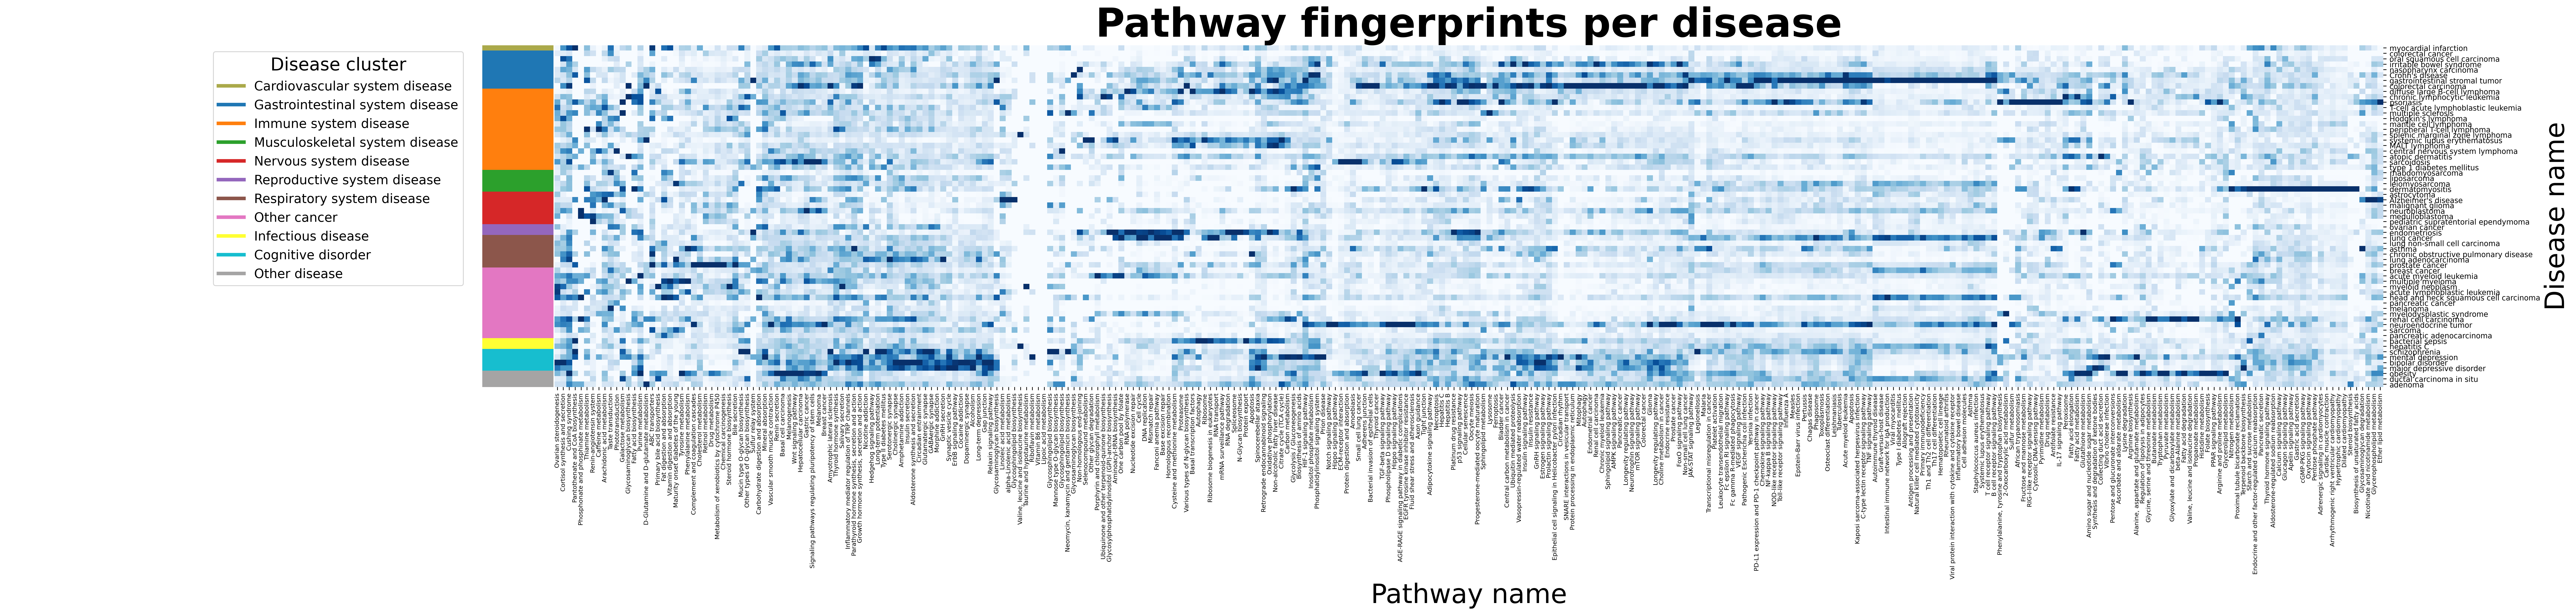

In [19]:
df_1 = df_and_normalize(pathway_similarity_per_doid1)
g = plot_df_with_clustering(df_1,os.path.join(figures_dir, "diseases__pathways_similarity.png"))

##### Use pathway ordering from clustering above for better comparability of methods

In [20]:
pathway_order =  [pathway_id_mapping[text_obj.get_text()] for text_obj in g.ax_heatmap.get_xmajorticklabels()]

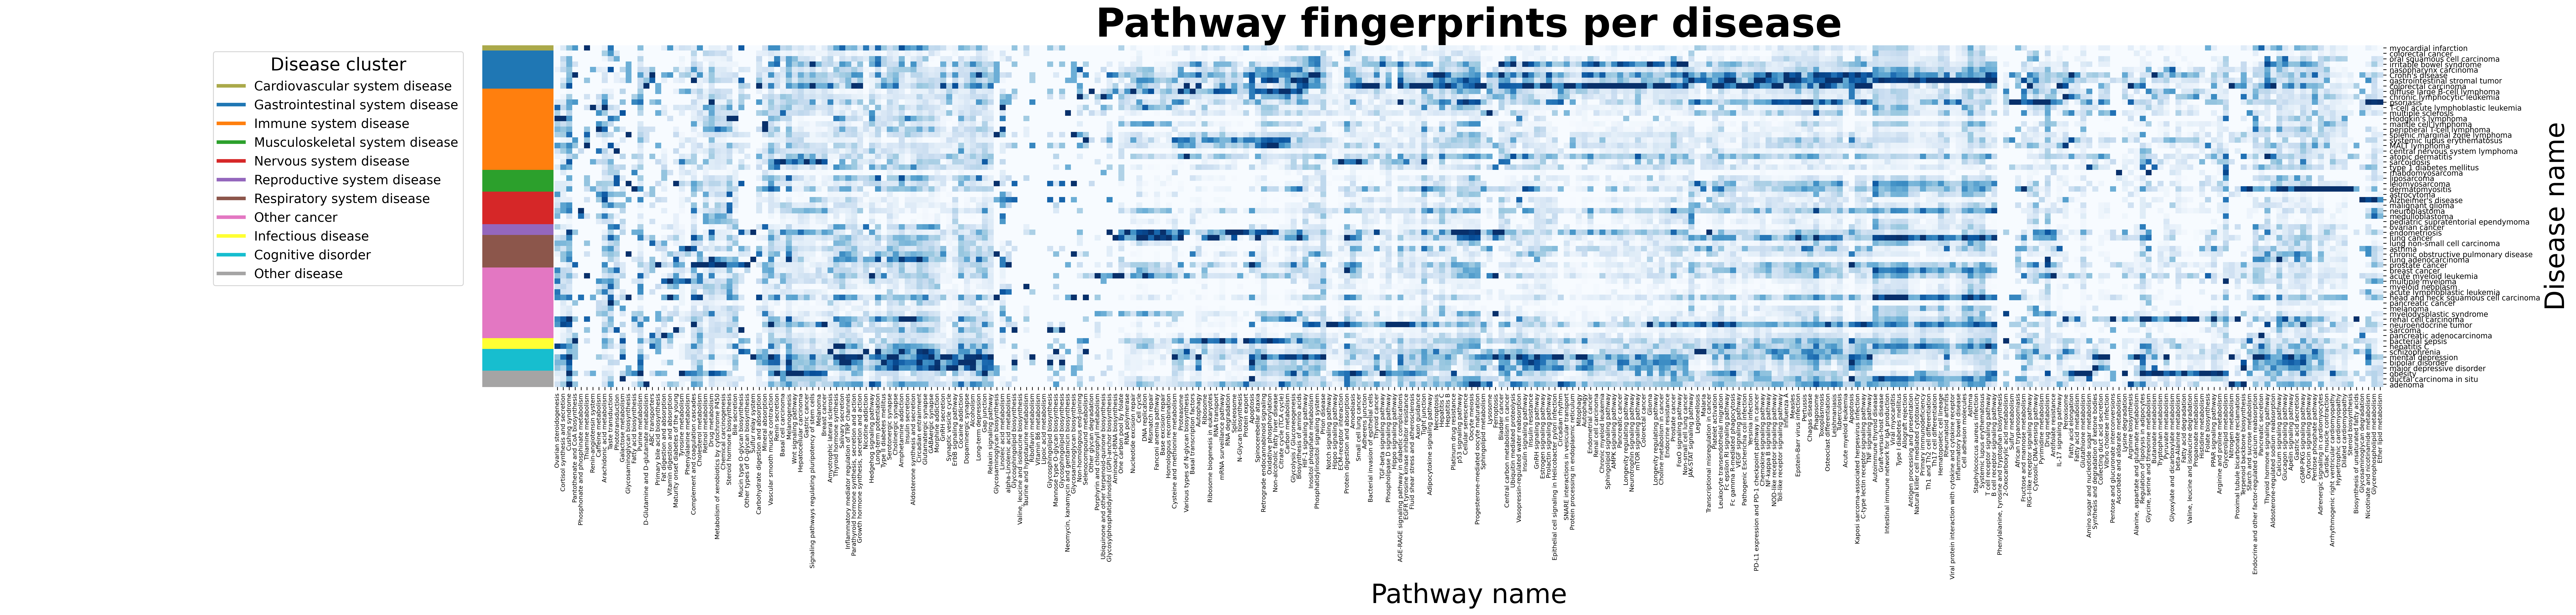

In [21]:
df_2 = df_and_normalize(pathway_similarity_per_doid2)
df_2 = reorder_df_columns(df_2, pathway_order)
plot_df(df_2,os.path.join(figures_dir, "diseases__pathways_similarity_via_interactome.png"))
plt.show()

##### Make the colorbar legend (must be added manually)

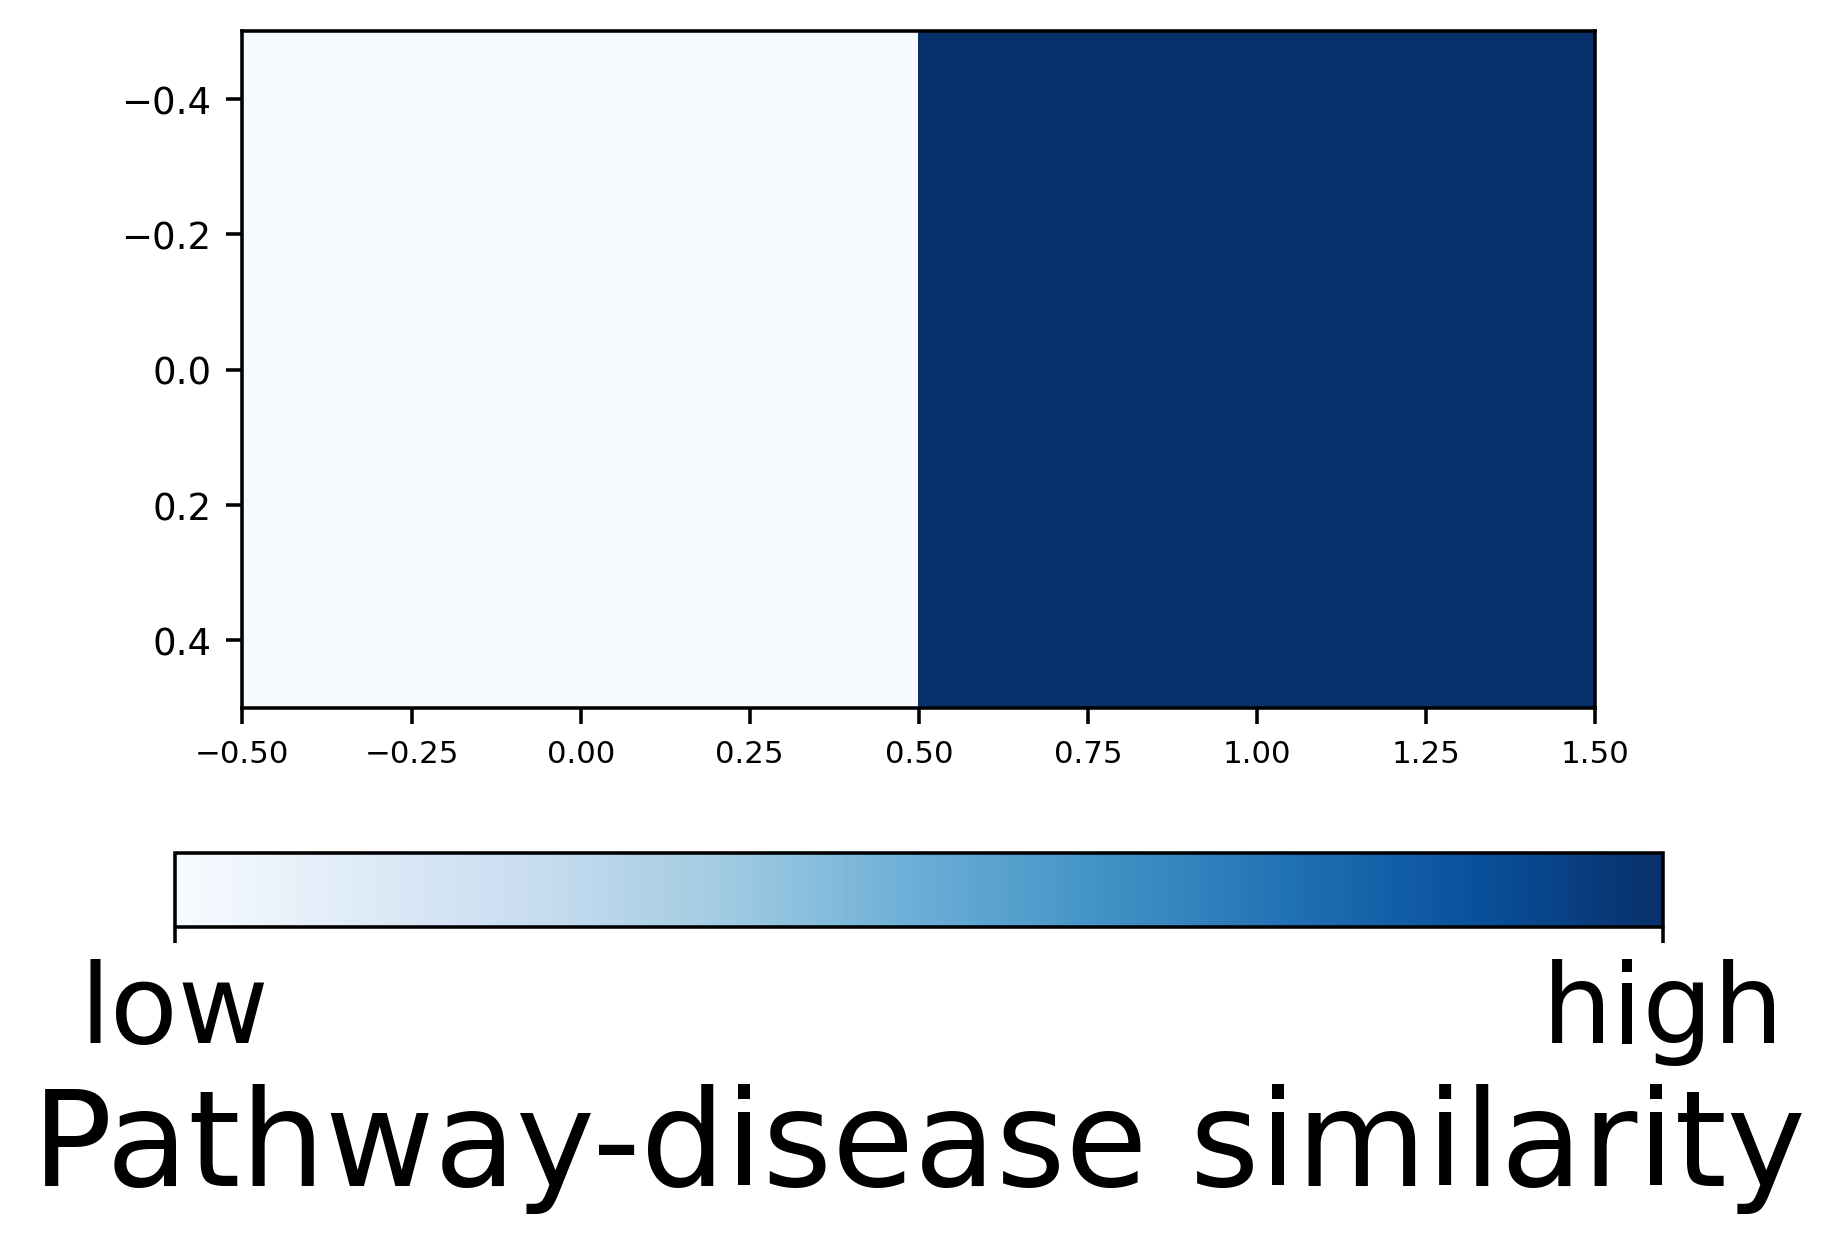

In [23]:
fig, ax = plt.subplots()

cax = ax.imshow([[0,1]], interpolation='nearest', cmap=blue_color_palette)

cbar = fig.colorbar(cax, ticks=[0, 1],orientation='horizontal')
cbar.ax.set_xticklabels(['low', 'high'], fontsize=25) 
cbar.set_label('Pathway-disease similarity',fontsize=30)
plt.savefig(os.path.join(figures_dir, "colorbar_for_heatmap.png"), bbox_inches='tight',dpi=320)